# Overview
 - Make predictions based on majority voting.
 - Reduce overfitting by drawing random combinations of the training set with repetition.
 - Build powerful models from <i>weak learners</i> that learn from their mistakes.

## Learning with ensembles
<b><u>ensemble learning</u></b>: is to combine different classifiers into a meta-classifier that has a better generalization performance than each individual classifier alone.

In [1]:
## ensemble error rate
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * 
             error**k * 
             (1-error)**(n_classifier - k) 
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

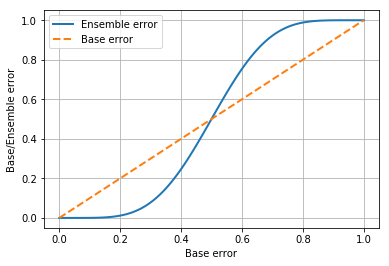

In [2]:
import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) 
              for error in error_range]
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(error_range, ens_errors, 
         label='Ensemble error', 
         linewidth=2)
plt.plot(error_range, error_range, 
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

### Implementing simple majority vote classifier

In [3]:
## weighted majority vote, with binary classification
import numpy as np
np.argmax(np.bincount([0,0,1],
                     weights=[0.2,0.2,0.6]))

1

In [4]:
## weighted majority vote, based on class probabilities
ex = np.array([[0.9, 0.1],
                [0.8, 0.2],
                [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
# p
np.argmax(p)

0

In [5]:
## Majority Mote Classifier
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'}
      Default: 'classlabel'
      If 'classlabel' the prediction is based on
      the argmax of class labels. Else if
      'probability', the argmax of the sum of
      probabilities is used to predict the class label
      (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers]
      Optional, default: None
      If a list of `int` or `float` values are
      provided, the classifiers are weighted by
      importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers,
                 vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = \
            {key: value for key, value in
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                              self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    ########
    # predict method
    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),
                                 axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in
                                      self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                           lambda x:
                           np.argmax(np.bincount(x,                                             
                                        weights=self.weights)),
                           axis=1,
                           arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Training vectors, where n_samples is
            the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, 
                               axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier,
                         self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in \
                    six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(
                        step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out
        
### try instead sklearn.ensemble.VotingClassifier

#### Combining different algorithms for classification with majority vote

In [6]:
## using iris dataset two classes
## (iris-versicolor and iris-virginica)
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
## split iris samples 50/50 train/test
X_train, X_test, y_train, y_test = \
        train_test_split(X, y,
                        test_size=0.5,
                        random_state=1)

In [8]:
## train 3 different classifiers-
## logistic regression, decision tree, and k-nearest neighbors
## and look at performances via 10-fold cross-validation
## before we combine
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                         C=0.001,
                         random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1,
                             criterion='entropy',
                             random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                           p=2,
                           metric='minkowski')
pipe1 = Pipeline([
        ['sc', StandardScaler()],
        ['clf', clf1]])
pipe3 = Pipeline([
        ['sc', StandardScaler()],
        ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),
                                              scores.std(),
                                              label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [9]:
## combining individual classifiers for majority rule voting
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print("Accuracy(ROC AUC): %0.2f (+/- %0.2f) [%s]" % 
          (scores.mean(), scores.std(), label))

Accuracy(ROC AUC): 0.92 (+/- 0.20) [Logistic Regression]
Accuracy(ROC AUC): 0.92 (+/- 0.15) [Decision Tree]
Accuracy(ROC AUC): 0.93 (+/- 0.10) [KNN]
Accuracy(ROC AUC): 0.97 (+/- 0.10) [Majority Voting]


### Evaluating and tuning ensemble classifier

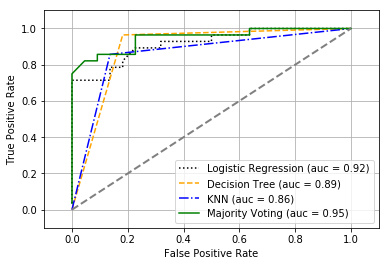

In [10]:
## compute ROC curves form test set to see if MajorityVoteClassifier
## generalizes well to unseen data
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
            in zip(all_clf, clf_labels, colors, linestyles):
        # assuming the labels of the positive class is 1
        y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                        y_score=y_pred)
        roc_auc = auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, color=clr,
                linestyle=ls,
                label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
        linestyle='--',
        color='gray',
        linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

C:\Users\param\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


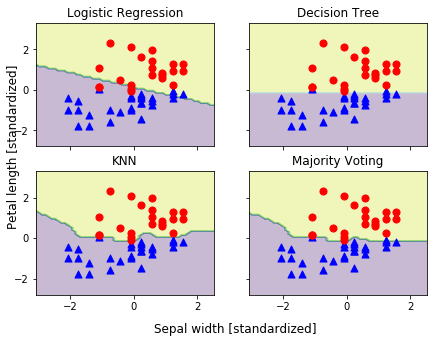

In [11]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)   
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5, 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)
plt.show()

In [12]:
## get params, so we can see which parameters for future tuning
## inside gridsearch
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

In [13]:
## let's tune inverse regulariztion param C of logistic regression
## and the depth of the tree via gridsearch for demonstration
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, 
                    param_grid=params, 
                    cv=10, 
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [14]:
## print different hyperparameter value combinations 
## and average roc auc scores computed via 10-fold cv (next 3)
for params, mean_score, scores in grid.grid_scores_:
    print('{:.3f} +/- {:.2f} {}'.format(mean_score, scores.std()/2, params))

0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


C:\Users\param\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [15]:
print('Best parameters: %s' % grid.best_params_)
## best if we choose lower regularization stength

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}


In [16]:
 print('Accuracy: %.2f' % grid.best_score_)

Accuracy: 1.00


### Bagging -- building an ensemble of classifiers from bootstrap samples

In [17]:
## using wine dataset
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 
                   'Malic acid', 'Ash', 
                   'Alcalinity of ash', 
                   'Magnesium', 'Total phenols', 
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins', 
                   'Color intensity', 'Hue', 
                   'OD280/OD315 of diluted wines', 
                   'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [18]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
59,2,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520
60,2,12.33,1.10,2.28,16.0,101,2.05,1.09,0.63,0.41,3.27,1.25,1.67,680
61,2,12.64,1.36,2.02,16.8,100,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450
62,2,13.67,1.25,1.92,18.0,94,2.10,1.79,0.32,0.73,3.80,1.23,2.46,630
63,2,12.37,1.13,2.16,19.0,87,3.50,3.10,0.19,1.87,4.45,1.22,2.87,420


In [19]:
## ecode class labels into binary format
## split 60/40
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.4, random_state=1)


In [20]:
## will use unpruned decision tree as base classifier asn
## create ensemble of 500 decision trees fitted on different
## bootstrap samples of training set
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=1,
                       random_state=1)

In [21]:
## now calculate the accuracy score fo the prediction on
## training and test sets to compare perfomance of bagging 
## classifier to performance of single unpruned tree
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' %
     (tree_train, tree_test))
#overfitting

Decision tree train/test accuracies 1.000/0.854


In [22]:
## now bag model
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' %
     (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.896


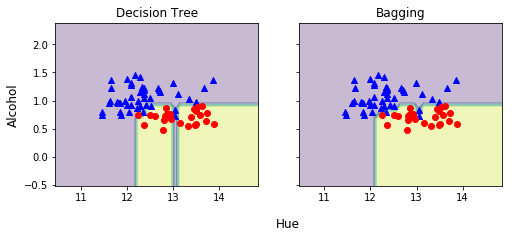

In [23]:
## compare decision regions between the two
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))
for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], 
                       X_train[y_train==0, 1], 
                       c='blue', marker='^')    
    axarr[idx].scatter(X_train[y_train==1, 0], 
                       X_train[y_train==1, 1], 
                       c='red', marker='o')    
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, 
         s='Hue', 
         ha='center', va='center', fontsize=12)
plt.show()

### Bagging Summary
We only looked at a very simple bagging example in this section. In practice, more complex classification tasks and datasets' high dimensionality can easily lead to overfitting in single decision trees and this is where the bagging algorithm can really play out its strengths. Finally, we shall note that the bagging algorithm can be an effective approach to reduce the variance of a model. However, bagging is ineffective in reducing model bias, which is why we want to choose an ensemble of classifiers with low bias, for example, unpruned decision trees.

### Leveraging weak learners via adaptive boosting (AdaBoost)

In [24]:
## using wine, train AdaBoostClassifier on 500 decision tree stumps
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                             max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=0)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' %
     (tree_train, tree_test))
## decision tree stump seems to overfit training data
## compared with unpruned tree from before

Decision tree train/test accuracies 0.845/0.854


In [25]:
## compare to adaboost
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' %
     (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.875


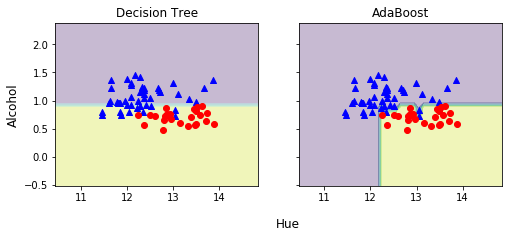

In [26]:
## let's see what decision regions look like
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))
for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)   
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], 
                       X_train[y_train==0, 1], 
                       c='blue', 
                       marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], 
                       X_train[y_train==1, 1], 
                       c='red',
                       marker='o')
    axarr[idx].set_title(tt)
    axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, 
         s='Hue', 
         ha='center', 
         va='center', 
         fontsize=12)    
plt.show()

Ensemble techniques are much more computationally complex compared to individual classifiers. Need to cosinder trade offs between compelxity and imporovement in predictive power when considering using ensemble methods.

# Summary
In this chapter, we looked at some of the most popular and widely used techniques for ensemble learning. Ensemble methods combine different classification models to cancel out their individual weakness, which often results in stable and well-performing models that are very attractive for industrial applications as well as machine learning competitions.

In the beginning of this chapter, we implemented a MajorityVoteClassifier in Python that allows us to combine different algorithm for classification. We then looked at bagging, a useful technique to reduce the variance of a model by drawing random bootstrap samples from the training set and combining the individually trained classifiers via majority vote. Then we discussed AdaBoost, which is an algorithm that is based on weak learners that subsequently learn from mistakes.